In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

#### Importing and degrading the SMICA map

In [2]:
smica = hp.read_map("/mnt/c/Users/hp/Downloads/COM_CMB_IQU-smica_2048_R3.00_full.fits")

In [5]:
smica = hp.ud_grade(smica, nside_out=128)
smica = hp.smoothing(smica, fwhm=np.radians(5))

#### Importing, degrading and modifying the mask

In [3]:
mask = hp.read_map("/mnt/c/Users/hp/Downloads/COM_Mask_CMB-common-Mask-Int_2048_R3.00.fits")

In [6]:
mask = hp.ud_grade(mask,nside_out=128)
mask = hp.smoothing(mask, fwhm=np.radians(5))

In [9]:
# introducing the cut off value for the mask
with np.nditer(mask, op_flags=['readwrite']) as it:
   for x in it:
     if x < 0.1: 
       x[...] = 0 * x
     else:
       x[...] = 1

#### Functions

In [ ]:
# defining array of pixels for given nside
Nside = 128
pixels = np.array([range(hp.nside2npix(Nside))])  #196608 pixels for 128 nside

In [231]:
# defining function that takes pixel as an argument and returns arrays of pixels that make a thin disc of specified radius
def get_thin_disc(p):
    mr , w = 20 , 2
    outer = mr + w
    inner = mr - w
    large_disc = np.array([hp.query_disc(nside=Nside, vec=hp.pix2vec(Nside,p), radius=np.radians(outer))])
    small_disc = np.array([hp.query_disc(nside=Nside, vec=hp.pix2vec(Nside,p), radius=np.radians(inner))])
    thin_disc = np.setdiff1d(large_disc,small_disc)
    return thin_disc

# defining function that takes the average of values of pixels from thin disc 
def get_value(mapp,maskk,pix):
    thin_disc = get_thin_disc(pix)
    temps = mapp[thin_disc]
    mask_ = maskk[thin_disc]
    val = (np.sum(temps)/np.sum(mask_))
    return val

def get_variance(mapp,maskk,pix):
    thin_disc = get_thin_disc(pix)
    temps = mapp[thin_disc]
    mask_ = maskk[thin_disc]
    var = (1/(np.sum(mask_)-1))*(np.sum(temps**2)-np.sum(temps))**2
    return var

#### Computing L1 (mean) and L2 (variance) maps

In [190]:
L1 = np.array([get_value(smica*mask,mask,pixel) for pixel in range(hp.nside2npix(Nside))])

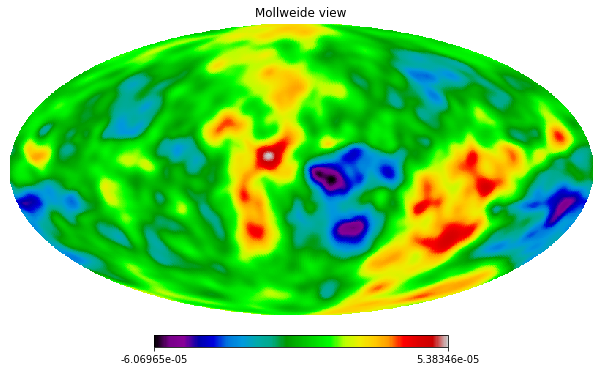

In [192]:
hp.mollview(L1,cmap="nipy_spectral")

In [232]:
L2 = np.array([get_variance(smica*mask,mask,pixel) for pixel in range(hp.nside2npix(Nside))])

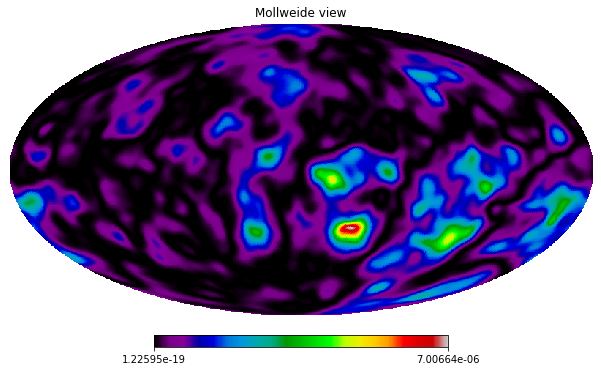

In [233]:
hp.mollview(L2, cmap="nipy_spectral")

#### Defining the loop of the largest value

In [ ]:
# finding the pixel that has the largest value(average) and defining the healpy map with masked loop
largest_avg = L1.max()
index = np.nonzero(L1 == largest_avg)
pix_index = index[0][0]
one_loop = get_thin_disc(pix_index)
loop_map = np.array([1 for pixel in range(hp.nside2npix(128))])
loop_map[one_loop]=0
largest_avg

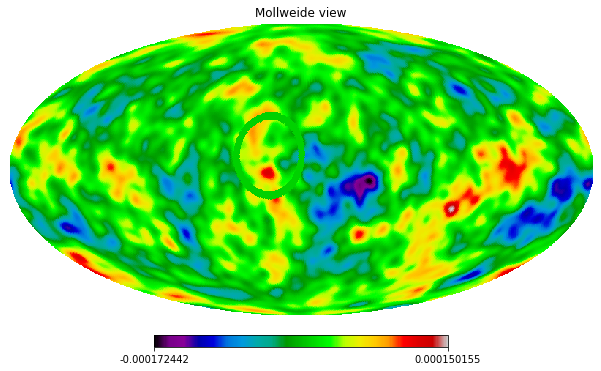

In [136]:
hp.mollview(smica * loop_map,cmap="nipy_spectral")

## Simulations

#### Importing, degrading and masking the simulated maps

Available maps: "00055" "00144" "00222" "00444" "00555" "00666" "00746" 00888" "00909" "00999" DONE

In [218]:
SIM = hp.read_map("/mnt/c/Users/hp/Downloads/dx12_v3_smica_cmb_mc_00055_raw.fits")

In [219]:
SIM = hp.ud_grade(SIM, nside_out=128)
SIM = hp.smoothing(SIM, fwhm=np.radians(5))

In [220]:
masked_SIM = SIM*mask

#### Computing L1S (mean) and L2S (variance)  of the simulated masked maps

In [111]:
L1S = np.array([get_value(masked_SIM,mask,pixel) for pixel in range(hp.nside2npix(Nside))])

In [221]:
L2S = np.array([get_variance(masked_SIM,mask,pixel) for pixel in range(hp.nside2npix(Nside))])

#### Saving data to the files

In [141]:
np.savetxt("L1_SIM1.txt", L1S)

In [222]:
np.savetxt("L2_SIM10.txt", L2S)

In [163]:
L2AllSims = L2S   # run only once for the first simulation

In [223]:
L2AllSims = np.concatenate((L2AllSims,L2S))

In [247]:
np.savetxt("L2_AllSims.txt", L2AllSims)  # run this after completing all simulations

## Histograms

#### Histograms of L1 and L2 SMICA maps

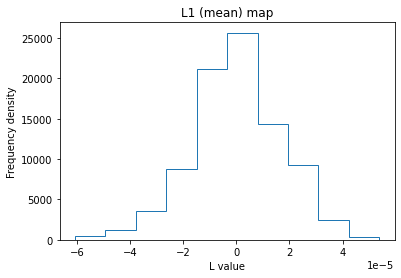

In [225]:
plt.hist(L1,histtype="step",density=True,stacked=True)
plt.title("L1 (mean) map")
plt.xlabel("L value")
plt.ylabel("Frequency density")
plt.show()

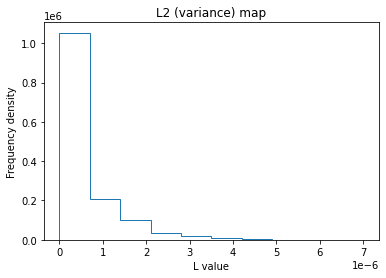

In [235]:
plt.hist(L2,histtype="step",density=True,stacked=True)
plt.title("L2 (variance) map")
plt.xlabel("L value")
plt.ylabel("Frequency density")
plt.show()

#### Histograms of sum of all simulations for L1 and L2 

In [226]:
L1AllSims = np.loadtxt("L1_AllSims.txt")

In [ ]:
L2AllSims = np.loadtxt("L2_AllSims.txt")

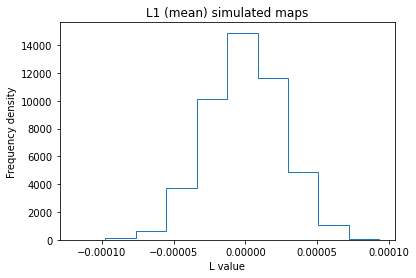

In [227]:
plt.hist(L1AllSims,histtype="step",density=True,stacked=True)
plt.title("L1 (mean) simulated maps")
plt.xlabel("L value")
plt.ylabel("Frequency density")
plt.show()

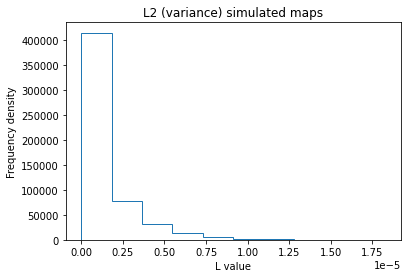

In [248]:
plt.hist(L2AllSims,histtype="step",density=True,stacked=True)
plt.title("L2 (variance) simulated maps")
plt.xlabel("L value")
plt.ylabel("Frequency density")
plt.show()

#### Plotting together histograms from simulations and SMICA map

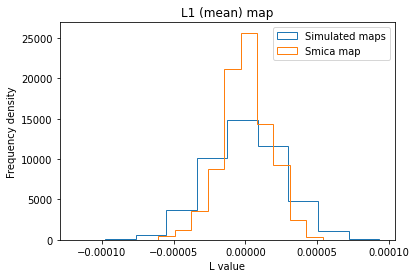

In [249]:
plt.hist(L1AllSims, label="Simulated maps",density=True,stacked=True,histtype="step")
plt.hist(L1,label='Smica map',density=True,stacked=True,histtype="step")
plt.title("L1 (mean) map")
plt.legend(loc='upper right')
plt.ylabel("Frequency density")
plt.xlabel("L value")
plt.show()

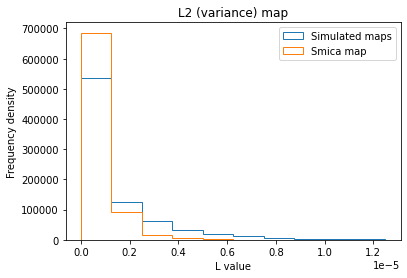

In [254]:
plt.hist(L2AllSims, label='Simulated maps',density=True,stacked=True,histtype="step",range=(0,1.25e-5))
plt.hist(L2,label='Smica map',density=True,stacked=True,histtype="step",range=(0,1.25e-5))
plt.title("L2 (variance) map")
plt.legend(loc='upper right')
plt.ylabel("Frequency density")
plt.xlabel("L value")
plt.show()

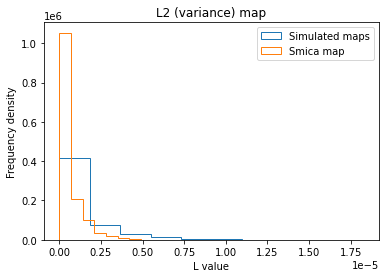

In [255]:
plt.hist(L2AllSims, label='Simulated maps',density=True,stacked=True,histtype="step")
plt.hist(L2,label='Smica map',density=True,stacked=True,histtype="step")
plt.title("L2 (variance) map")
plt.legend(loc='upper right')
plt.ylabel("Frequency density")
plt.xlabel("L value")
plt.show()

### Miscellaneous, Visuals

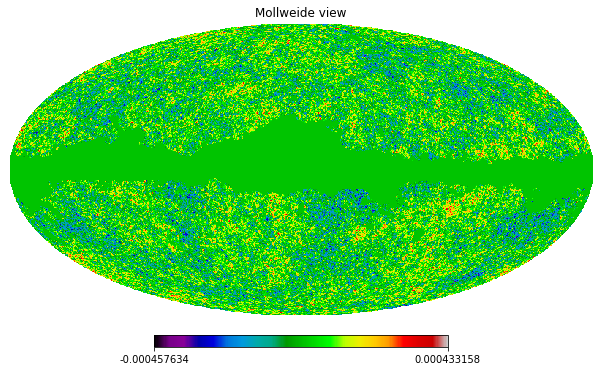

In [4]:
hp.mollview(smica*mask,cmap="nipy_spectral") # before downgrading and smoothing

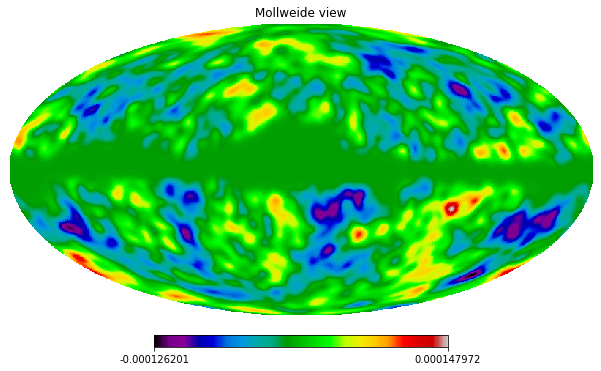

In [7]:
hp.mollview(smica*mask,cmap="nipy_spectral")  # after degrading but before cut off threshold

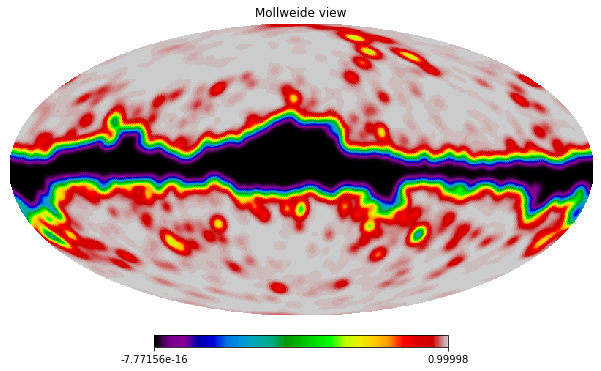

In [8]:
hp.mollview(mask, cmap="nipy_spectral")  # beautiful mask rainbow, mask after downgrading

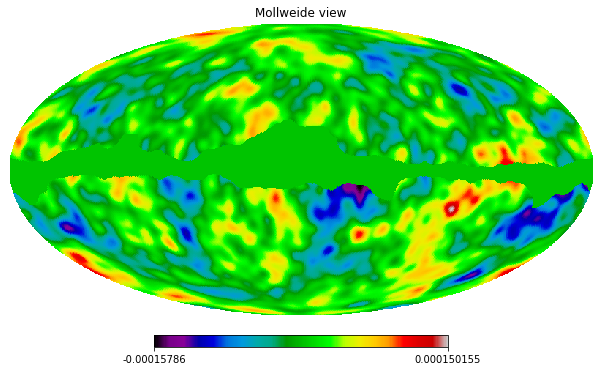

In [11]:
hp.mollview(masked_smica,cmap = "nipy_spectral") # after downgrading and after introducing the cut off value for the mask

In [ ]:
4605.5
5027.6
5740.9
5947.4
6218.3

16.042
17.558
20.150
20.908
21.908


In [261]:
import math
x=6218.3
y=21.908
lambdax = x*math.sqrt(0.0009+(0.0333/y)**2)
lambdax

186.78829023311934